# Clustering Similar Documents

In this class we will see how to cluster similar documents using K-Means and K-Medoids clustering.

For **Chinese characters**, we need a different approach because Chinese text doesn't use spaces to separate words. The first and most important step is word segmentation. A very popular and effective library for this is **jieba**

For **English text**, the equivalent process is to use a library like NLTK (Natural Language Toolkit) to extract nouns. We can replace the hannanum.nouns() logic with NLTK's tokenizing and Part-of-Speech (POS) tagging functions.

In [ ]:
# pip install pyclustering

In [2]:
import pandas as pd
from konlpy.tag import Hannanum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from pyclustering.cluster import kmedoids
import numpy as np

**Konlpy** (a Korean NLP library) requires a **Java Development Kit** (JDK) to run. These commands set up a Conda environment, install OpenJDK, and install Konlpy.

1. conda activate textmining (you should make env first)
2. conda install -c conda-forge openjdk=17 jpype1
3. pip install -U konlpy

- Check: conda list | findstr openjdk
 
(if you see "openjdk" - OK.)

In [1]:
import sys
from pathlib import Path

env = Path(sys.prefix)
cands = list(env.glob("**/jvm.dll"))
print("Conda env:", env)
print("Found JVM dlls:", [str(p) for p in cands])

Conda env: C:\Users\dadab\miniconda3\envs\textmining
Found JVM dlls: ['C:\\Users\\dadab\\miniconda3\\envs\\textmining\\Library\\lib\\jvm\\bin\\server\\jvm.dll']


In [3]:
from pathlib import Path
import os, sys, jpype
from konlpy import jvm as konlpy_jvm

# 1) Point to the DLL you found
jvm_path = Path(r"C:\\Users\\***\\miniconda3\\envs\\textmining\\Library\\lib\\jvm\\bin\\server\\jvm.dll")
assert jvm_path.is_file(), f"Not found: {jvm_path}"

os.environ["JAVA_HOME"] = str(jvm_path.parents[4])   

# 2) Start JVM once per Python process
if not jpype.isJVMStarted():
    konlpy_jvm.init_jvm(jvmpath=str(jvm_path), max_heap_size=2048)

In [4]:
# Use Hannanum
from konlpy.tag import Hannanum
hannanum = Hannanum()

In [5]:
print(hannanum.nouns("한나눔 형태소 분석 테스트 성공!"))

['한나눔', '형태소', '분석', '테스트', '성공']


"Hannanum morpheme analysis test success!"
- Simple Tokenizer: Splits a sentence only by spaces or punctuation. (e.g., "Hannanum", "morpheme", "analysis", "test", "success!")
- Morphological Analyzer (Hannanum): Splits a sentence into morphemes (the smallest meaningful units) and tags their part of speech (noun, verb, etc.).

### 1. **Load Article Content**

In [7]:
# Loads the dataset from a CSV file into a pandas DataFrame named Data
Data = pd.read_csv(r"...\군집분석데이터.csv",encoding='cp949')

In [8]:
Data

,검색어,기사내용
0,유한양행,유한양행은 얀센 바이오테크(Janssen Biotech Inc)와 EGFR표적 항암...
1,유한양행,유한양행이 1조4000억원 규모의 기술이전 계약 체결 소식에 가격제한폭까지 치솟았다...
2,유한양행,유한양행이 다국적 제약사 얀센에 기술수출했다는 소식에 주가가 5일 장 초반 상한가를...
3,유한양행,"유한양행은 얀센 바이오테크((Janssen Biotech, Inc.)와 EGFR(상..."
4,유한양행,유한양행이 1조4000억원 규모 기술 수출 소식에 가격제한폭까지 치솟았다. 유한양행...
5,라돈,"최근 침대 매트리스에 이어 온수매트에서도 라돈이 검출됐다는 소식이 알려지면서, 가정..."
6,라돈,"침대, 생리대, 마스크 등에서 라돈이 검출되면서, 발암 물질 ‘라돈’에 대한 관심..."
7,라돈,하이젠 온수매트가 '라돈 온수매트'로 언급되고 있다.\n\n최근 한 온라인커뮤니티에...
8,라돈,겨울 난방 제품인 온수매트에서 라돈이 검출된 가운데 해당 업체가 별 문제가 되지 않...
9,라돈,"매트리스, 생리대에 이어 온수 매트에서도 라돈이 검출돼 이슈로 떠올랐다.\n\n5일..."


- This dataset matches article content (documents) collected by search query (topic).
- The SearchQuery = 검색어 column acts as the true label (Label), and the ArticleContent = 기사내용 column is the actual data (Feature) for clustering.

- **유한양행 :** News mainly about cancer drug technology export (Janssen Biotech Inc, EGFR).
- **라돈 :** News about social issues, radon detection in items like bed mattresses, hot water mats, and sanitary pads.
- **복면가왕 왕밤빵 :** Entertainment news about the identity of a contestant named Wang S-Bam on the MBC show 'King of Mask Singer'.

In [9]:
# Print the content of the Article Content = 기사내용 column at index 0
print(Data['기사내용'][0]) 

유한양행은 얀센 바이오테크(Janssen Biotech Inc)와 EGFR표적 항암 치료제의 기술이전 계약을 체결했다고 5일 공시했다.

총 기술수출금액은 12억5500만달러(한화 약 1조3416억원)로 계약금은 5000만달러다. 개발과 허가, 매출에 따른 단계별 마일스톤으로 총 12억500만달러를 수령 예정이며 경상기술료는 순매출액에 따라 책정된다. 

유한양행 관계자는 "본 기술이전 계약의 수익 인식은 임상시험과 허가 등 성공여부에 따라 달라질 수 있으며 미실현 가능성도 있다"고 덧붙였다. 


### 2. **Extract Nouns using Hannanum Morphological Analyzer**

In [10]:
docs = []
 
for i in Data['기사내용']: # Use translated column name
    # Analyzes sentences into morphemes, then extracts only the nouns.
    docs.append(hannanum.nouns(i))

- **morphs()**: Splits the sentence into all morphemes.
- **pos()**: Splits the sentence into pairs (tuples) of morphemes and their Part-of-Speech (POS) tags.

**Example**
- morphs: ['Data', 'analysis', 'is', 'fun', '.']
- pos: [('Data', 'N'), ('analysis', 'N'), ('is', 'J'), ('fun', 'P'), ('.', 'S')]
    - N: Noun - e.g., 'Data', 'analysis'
    - S: Symbol - e.g., '.', '!'
    - J: Josa (Postpositional particle) - A grammatical feature in Korean.
    - P: Predicate - Verb or Adjective, like 'fun'
    - E: Eomi (Ending) - The ending of a predicate.
- nouns: ['Data', 'analysis']

In [11]:
len(docs) # docs is a list containing 15 'lists of nouns'

15

In [12]:
docs[0]

['유한양행',
 '얀센',
 '바이오테크(Janssen',
 '표적',
 '항암',
 '치료제',
 '기술이전',
 '계약',
 '체결',
 '5일',
 '공시',
 '기술수출금액',
 '12억5500만달러(한화',
 '약',
 '1조3416억원',
 '계약금',
 '5000만달러',
 '개발',
 '허가',
 '매출',
 '단계별',
 '마일스톤',
 '12억500만달러',
 '수령',
 '예정',
 '경상기술료',
 '순매출액',
 '책정',
 '유한양행',
 '관계자',
 '기술이전',
 '계약',
 '수익',
 '식',
 '임상시험',
 '허가',
 '등',
 '성공여부',
 '수',
 '미실현',
 '가능성']

### 3. **Join the Extracted Nouns into a Single String with Spaces**

In [13]:
for i in range(len(docs)):
    # The ' '.join() function combines words in a list into one string, separated by a space (' ').
    docs[i] = ' '.join(docs[i])

In [14]:
docs[0]

'유한양행 얀센 바이오테크(Janssen 표적 항암 치료제 기술이전 계약 체결 5일 공시 기술수출금액 12억5500만달러(한화 약 1조3416억원 계약금 5000만달러 개발 허가 매출 단계별 마일스톤 12억500만달러 수령 예정 경상기술료 순매출액 책정 유한양행 관계자 기술이전 계약 수익 식 임상시험 허가 등 성공여부 수 미실현 가능성'

We converted each item in the docs list (which is currently a list of nouns) into a single string of space-separated nouns. This string format is required by **CountVectorizer**.

**Why is this step important?**
1. Format Conversion: Vectorization tools like TfidfVectorizer or CountVectorizer expect a list of strings ('noun1 noun2'), not a list of lists (['noun1', 'noun2']).
2. Noise Removal: This uses a clean text for vectorization, containing only meaningful nouns. It removes "noise" like particles, conjunctions, and punctuation that were in the original text.

### 4. Vectorization - DTM (Document-Term Matrix)

- Each document is a row, each word is a column.
- The matrix value represents the frequency of that word in the document.

In [15]:
# A tool to convert text into word occurrence counts (frequency).
vec = CountVectorizer() # initializes the vectorizer.
X = vec.fit_transform(docs)


- **fit** (Learn): Scans all documents in `docs` to build a vocabulary (dictionary) of all unique words.
- **transform** (Convert): Based on the learned vocabulary, counts "how many times each word appeared" for each document in `docs`.

| The output (0, 406) 2 (as an example) would mean: "In document 0, the word at vocabulary index 406 appeared 2 times." This format saves memory by only storing non-zero values.

In [16]:
# Check the content of X (in compressed sparse format)
print(X)

  (0, 406)	2
  (0, 368)	1
  (0, 248)	1
  (0, 73)	1
  (0, 545)	1
  (0, 561)	1
  (0, 523)	1
  (0, 172)	2
  (0, 125)	2
  (0, 507)	1
  (0, 55)	1
  (0, 137)	1
  (0, 171)	1
  (0, 6)	1
  (0, 560)	1
  (0, 15)	1
  (0, 127)	1
  (0, 46)	1
  (0, 105)	1
  (0, 566)	2
  (0, 228)	1
  (0, 194)	1
  (0, 225)	1
  (0, 4)	1
  (0, 333)	1
  :	:
  (14, 515)	1
  (14, 208)	1
  (14, 19)	1
  (14, 345)	1
  (14, 178)	2
  (14, 234)	1
  (14, 572)	1
  (14, 87)	2
  (14, 505)	1
  (14, 451)	1
  (14, 316)	1
  (14, 173)	1
  (14, 109)	1
  (14, 419)	1
  (14, 88)	1
  (14, 20)	1
  (14, 273)	1
  (14, 578)	1
  (14, 213)	1
  (14, 274)	1
  (14, 94)	1
  (14, 181)	1
  (14, 495)	1
  (14, 283)	1
  (14, 232)	1


- Rows: Each document in `docs` (each article).
- Columns: All unique words learned during the `fit` process (e.g., 'Yuhan', 'Radon', 'mattress', 'Wang S-Bam', 'cancer').
- Value: The frequency (count) of a specific word (column) appearing in a specific document (row).

In [17]:
# X is originally in a compressed format (sparse matrix) --> toarray() converts it to a standard array (table) including all 0s.
# Get the list of all learned words (features) and use them as column names.
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

In [18]:
df

,10대,10배,10분,12억500,12억500만달러,12억5500,12억5500만달러,12억5천500,15명,16,...,협조,호소력,홈페이지,확대,확인,확충,환경부,활동,후보물질,흡연
0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,1,0,0,0,1
7,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


# **K-Means Clustering**
- K-Means is a representative clustering algorithm that groups similar data into 'K' clusters.

In [23]:
kmeans = KMeans(n_clusters=3).fit(df) # 3 clusters (groups)

# n_clusters=3: Sets the number of clusters to 3 (since we know there are 3 topics).
# .fit(df): Trains the model on the DTM data.

- K-Means starts by placing initial cluster centers **randomly**.
- Because this starting point differs each time, the final clustering result based on that starting point can also differ.

In [24]:
# K-Means clustering result
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0])

# **Dimensionality Reduction with PCA for Visualization**

We can't plot 581 dimensions, so we use PCA (Principal Component Analysis) to reduce it to 2.

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [26]:
pca = PCA(n_components=2) # 2 new axes (principal component 1, principal component 2)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# 1. PCA(n_components=2): Initializes PCA to reduce data to 2 dimensions.
# 2. pca.fit_transform(df): Applies the PCA reduction to the DTM.
# 3. The result is stored in a new DataFrame, principalDf.

In [27]:
principalDf

,principal component 1,principal component 2
0,-2.245406,-4.167459
1,-3.613949,-9.898588
2,-2.932636,-7.159355
3,-2.142772,-3.757116
4,-3.397882,-8.904276
5,-3.456161,0.931164
6,-4.172639,2.527028
7,-6.418892,7.240864
8,-7.928538,10.011247
9,-7.161776,8.881849


In [28]:
principalDf.index=Data['검색어'] # Apply labels

In [29]:
principalDf

,principal component 1,principal component 2
검색어,,
유한양행,-2.245406,-4.167459
유한양행,-3.613949,-9.898588
유한양행,-2.932636,-7.159355
유한양행,-2.142772,-3.757116
유한양행,-3.397882,-8.904276
라돈,-3.456161,0.931164
라돈,-4.172639,2.527028
라돈,-6.418892,7.240864
라돈,-7.928538,10.011247


In [30]:
# Re-check the clustering assignment results to be used for visualization.
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0])

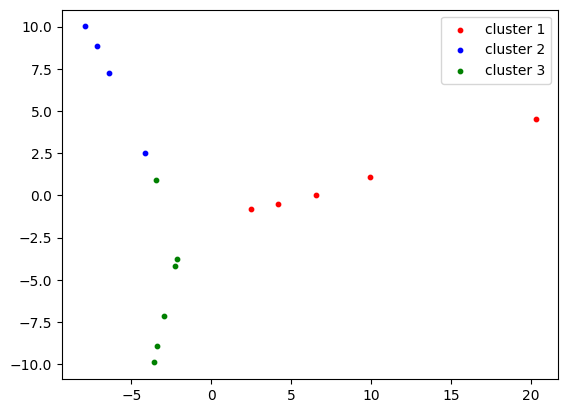

In [31]:
plt.scatter(principalDf.iloc[kmeans.labels_ == 0, 0], principalDf.iloc[kmeans.labels_ == 0, 1], s = 10, c = 'red', label = 'cluster 1')
plt.scatter(principalDf.iloc[kmeans.labels_ == 1, 0], principalDf.iloc[kmeans.labels_ == 1, 1], s = 10, c = 'blue', label = 'cluster 2')
plt.scatter(principalDf.iloc[kmeans.labels_ == 2, 0], principalDf.iloc[kmeans.labels_ == 2, 1], s = 10, c = 'green', label = 'cluster 3')
plt.legend()

- Each dot: Represents 1 article (15 total).
- x-axis, y-axis: The 2 virtual axes compressed by PCA (reduced from 581 word-dimensions).
- Color (red, blue, green): Represents the groups (0, 1, 2) classified by K-Means.

In [32]:
# Create a cross-tabulation (contingency table) comparing the 'SearchQuery' column and 'kmeans.labels_'
comparison = pd.crosstab(Data['검색어'], kmeans.labels_)
 
# print() is not needed in a notebook cell to display
comparison

col_0,0,1,2
검색어,,,
라돈,0,4,1
복면가왕 왕밤빵,5,0,0
유한양행,0,0,5


# **K-Medoids Clustering**

K-Means and K-Medoids are similar, but differ in how they define the cluster center:
- **K-Means:** The center is the *mean* (average) of all points in the cluster. This center might be a virtual point that doesn't exist in the data.
- **K-Medoids:** The center is an *actual data point* (a "medoid") from the cluster that is most central.

In [33]:
from pyclustering.cluster.kmedoids import kmedoids

In [34]:
kmedoids_instance = kmedoids(df.to_numpy(), initial_index_medoids=np.random.randint(15, size=3))
# Input the numeric data (NumPy array of df)
# Randomly select 3 of the 15 documents (size=3) to use as "initial medoids"

In [35]:
kmedoids_instance.process(); # Run (train) the K-Medoids model

In [36]:
clusters = kmedoids_instance.get_clusters() # Get the K-Medoids clustering results.
clusters

[[7, 8, 9], [10], [0, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14]]

In [37]:
kmedoids_instance = kmedoids(df.to_numpy(), initial_index_medoids=np.random.randint(15, size=3))
kmedoids_instance.process();
clusters = kmedoids_instance.get_clusters()
clusters

[[7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14], [10]]

Just like with K-Means, `initial_index_medoids` (the starting representative points) are chosen randomly by `np.random.randint` each time, so the clustering results will change with each execution.

### Use np.random.seed() (For Reproducibility)

In [40]:
import numpy as np

# Set a seed (any number will work)
np.random.seed(42) 

# This will now produce the same indices every time
initial_indices = np.random.randint(15, size=3) 

kmedoids_instance = kmedoids(df.to_numpy(), initial_index_medoids=initial_indices)

kmedoids_instance.process();
clusters = kmedoids_instance.get_clusters()
clusters

[[7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14], [10]]